# Best Practices - H2O AutoML

This tutorial focuses on two areas for the data scientist to ensure the best performance by AutoML: 

* choosing the correct validation data
* feature engineering

## Section 1 - Choosing the Correct Validation Data

For this tutorial, we want to use H2O AutoML to build a model to predict the price of Airbnb's: <https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data>.

All AutoML software follows the same basic approach: try multiple models and see which one performs the best.  Where the data scientist comes into play is making sure that the way the AutoML framework measures "best" is in agreement with how this model will be used in real life. 

For example, if you are building a model that will be used to predict sales in a new territory, then you would want AutoML to use validation data that consists of a different territory than what is seen in the training data.  If you use the default cross validation setting, you will most likely get over optimistic results. 

In this tutorial, we will show how to use AutoML if you expect the scoring data to be the same as your training data and if you expect the socring data to encounter a new situation.


### Use Case 1 - Random Split

#### Step 1: Import Data

In [24]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "12.0.2" 2019-07-16; Java(TM) SE Runtime Environment (build 12.0.2+10); Java HotSpot(TM) 64-Bit Server VM (build 12.0.2+10, mixed mode, sharing)
  Starting server from /Users/megankurka/env2/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmp3wz7idm2
  JVM stdout: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmp3wz7idm2/h2o_megankurka_started_from_python.out
  JVM stderr: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmp3wz7idm2/h2o_megankurka_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.4
H2O cluster version age:,2 months
H2O cluster name:,H2O_from_python_megankurka_m5wc4m
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


In [25]:
data_path = "../../../../Data/Airbnb/AB_NYC_2019.csv"
data = h2o.import_file(data_path, destination_frame = "airbnb_data", col_types = {"host_id": "enum"})

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [26]:
data.head()

id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.6475,-73.9724,Private room,149,1,9,2018-10-19 00:00:00,0.21,6,365
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.7536,-73.9838,Entire home/apt,225,1,45,2019-05-21 00:00:00,0.38,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.809,-73.9419,Private room,150,3,0,,nan,1,365
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.6851,-73.9598,Entire home/apt,89,1,270,2019-07-05 00:00:00,4.64,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.7985,-73.944,Entire home/apt,80,10,9,2018-11-19 00:00:00,0.1,1,0
5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.7477,-73.975,Entire home/apt,200,3,74,2019-06-22 00:00:00,0.59,1,129
5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.6869,-73.956,Private room,60,45,49,2017-10-05 00:00:00,0.4,1,0
5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.7649,-73.9849,Private room,79,2,430,2019-06-24 00:00:00,3.47,1,220
5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.8018,-73.9672,Private room,79,2,118,2017-07-21 00:00:00,0.99,1,0
5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.7134,-73.9904,Entire home/apt,150,1,160,2019-06-09 00:00:00,1.33,4,188


#### Step 2: Split Data into Training and Testing

For Use Case 1, we will be splitting the data into training and testing at random.

In [27]:
train, test = data.split_frame(seed = 1234, destination_frames = ["train.hex", "test.hex"])

#### Step 2: Check for Drift

We will now check if there is any drift between our training and testing dataset.  This step is important because if drift is detected, we should not use AutoML's default cross validation but should instead provide our own validation data.  We know there should be no drift since we just randomly split our data.

In [28]:
train["is_train"] = 1
test["is_train"] = 0

drift_data = train.rbind(test)
drift_data["is_train"] = drift_data["is_train"].asfactor()

In [29]:
drift_data["is_train"].table()

is_train,Count
0,12213
1,36682


In [30]:
from h2o.estimators.xgboost import H2OXGBoostEstimator

drift_model = H2OXGBoostEstimator(model_id = "drift_model", nfolds = 5, seed = 1234)
drift_model.train(y = "is_train", training_frame=drift_data)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [31]:
drift_model.auc(xval = True)

0.4972291493850322

We can see that our model has horrible performance.  We are not able to separate the training data from the testing data. This tell us that we can use AutoML's default cross validation as validation.

#### Step 4: Run AutoML

In [13]:
x = list(set(train.col_names) - set(["price", "is_train", "id", "host_name"]))

In [33]:
from h2o.automl import H2OAutoML
# Run AutoML for 10 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=10, seed=1234, sort_metric="MAE", project_name = "random_split")
aml.train(x=x, y="price", training_frame=train, leaderboard_frame = test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


Our leaderboard is ordered by MAE (the model with the smallest MAE on the leaderboard frame is seen at the top).

In [34]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head() 

model_id,mae,mean_residual_deviance,rmse,mse,rmsle
XGBoost_1_AutoML_20200424_191834,60.6917,35856.6,189.358,35856.6,nan
StackedEnsemble_BestOfFamily_AutoML_20200424_191834,60.8347,35215.5,187.658,35215.5,0.46247
StackedEnsemble_AllModels_AutoML_20200424_191834,61.5207,34956.1,186.966,34956.1,0.466011
XGBoost_2_AutoML_20200424_191834,61.8524,36990,192.328,36990,0.476568
XGBoost_3_AutoML_20200424_191834,62.0047,36340,190.631,36340,0.491189
DRF_1_AutoML_20200424_191834,62.4632,37461.4,193.549,37461.4,0.472444
GBM_1_AutoML_20200424_191834,62.5812,36489.7,191.023,36489.7,nan
GBM_2_AutoML_20200424_191834,63.4477,37935.7,194.771,37935.7,nan
GBM_5_AutoML_20200424_191834,63.6079,37433,193.476,37433,0.484703
GBM_3_AutoML_20200424_191834,63.69,38300.5,195.705,38300.5,nan


#### Step 5: Review Best Model

The best model is denoted as the `leader`.  We can review this model in more detail.

In [35]:
best_model = aml.leader

In [36]:
best_model.model_performance(test)


ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 35856.623696727744
RMSE: 189.358452931808
MAE: 60.69170458473172
RMSLE: NaN
Mean Residual Deviance: 35856.623696727744


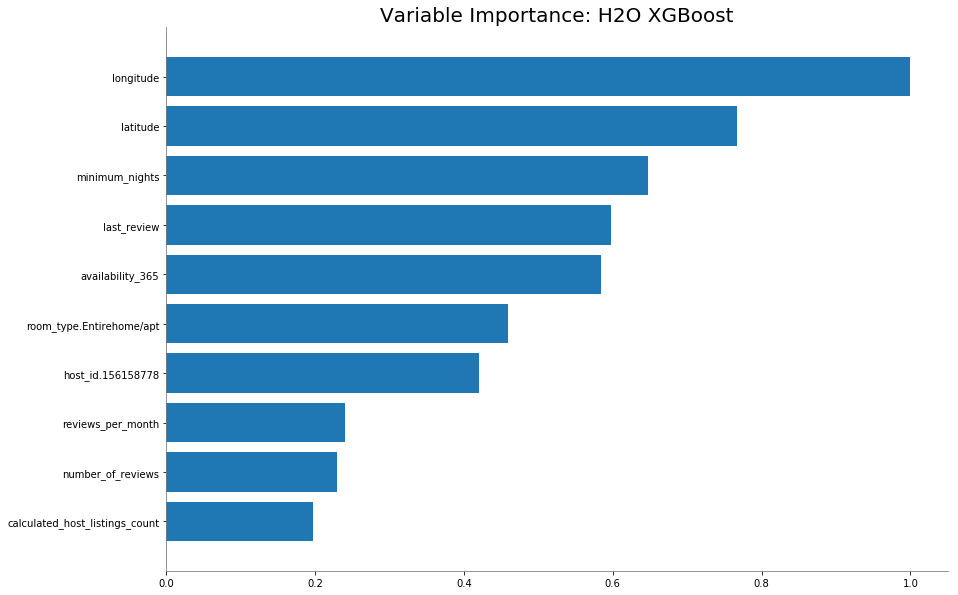

In [37]:
%matplotlib inline
best_model.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


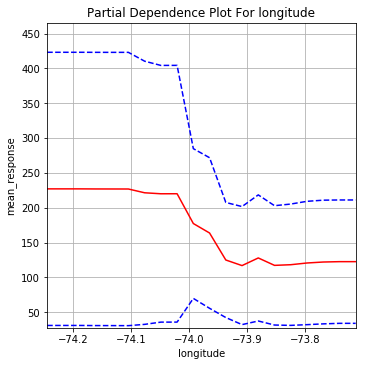

In [38]:
best_model.partial_plot(train, cols = ["longitude"], figsize = (5, 5));

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


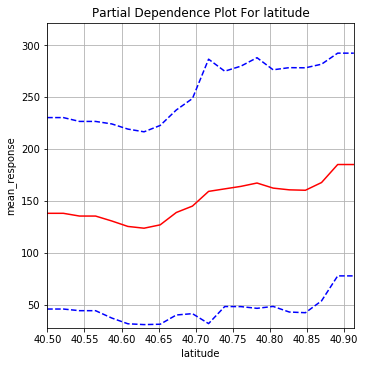

In [39]:
best_model.partial_plot(train, cols = ["latitude"], figsize = (5, 5));

In [40]:
h2o.cluster().shutdown()

H2O session _sid_ab9c closed.


### Use Case 2 - Split by Neighborhood Group

In this case, we will assume that the model will be scored on airbnb's from a new neighbourhood group.

#### Step1: Import Data

In [1]:
import h2o

In [2]:
import time
time.sleep(5)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "12.0.2" 2019-07-16; Java(TM) SE Runtime Environment (build 12.0.2+10); Java HotSpot(TM) 64-Bit Server VM (build 12.0.2+10, mixed mode, sharing)
  Starting server from /Users/megankurka/env2/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmp_qpt9dxy
  JVM stdout: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmp_qpt9dxy/h2o_megankurka_started_from_python.out
  JVM stderr: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmp_qpt9dxy/h2o_megankurka_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.4
H2O cluster version age:,2 months and 3 days
H2O cluster name:,H2O_from_python_megankurka_7eohen
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


In [3]:
data_path = "../../../../Data/Airbnb/AB_NYC_2019.csv"
data = h2o.import_file(data_path, destination_frame = "airbnb_data", col_types = {"host_id": "enum"})

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Step 1: Split Data into Training and Testing

Since our model will be used to predict price on new neighborhood groups, we will create the test data so that it consists of only airbnb's whose `neighbourhood_group` = "Queens".

In [4]:
train = data[data["neighbourhood_group"] != "Queens"]
test = data[data["neighbourhood_group"] == "Queens"]

In [5]:
train["neighbourhood_group"] = train["neighbourhood_group"].ascharacter().asfactor()
test["neighbourhood_group"] = test["neighbourhood_group"].ascharacter().asfactor()

#### Step 3: Check for Drift

We will now check if there is any drift between our training and testing dataset.  We should detect drift since our test data consists of a never before seen `neighbourhood_group`.

In [6]:
train["is_train"] = 1
test["is_train"] = 0

drift_data = train.rbind(test)
drift_data["is_train"] = drift_data["is_train"].asfactor()

In [7]:
drift_data["is_train"].table()

is_train,Count
0,5666
1,43229


In [11]:
drift_model = H2OXGBoostEstimator(model_id = "drift_model", nfolds = 5, seed = 1234)
drift_model.train(y = "is_train", training_frame=drift_data)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [12]:
drift_model.auc(xval = True)

1.0

We can see that our model has perfect performance.  This indicates that there is significant drift between the training and testing dataset. This makes sense since we have created our test data to mimic what will be seen in production (scoring on Airbnb's with a different `neighbourhood_group`).  

For this use case, we should not use AutoML's default cross validation.  Instead, we should create a validation data that consists of a new Neighbourhood Group or use `neighbourhood_group` as the `fold_column`.

#### Step 4: Run AutoML

In [15]:
# Run AutoML for 10 base models (limited to 1 hour max runtime by default)
aml_neighbourhood_group = H2OAutoML(max_models=10, seed=1234, sort_metric="MAE", project_name = "neighbourhood_group_split")
aml_neighbourhood_group.train(x=list(set(x) - set(["neighbourhood_group"])), y="price", fold_column = "neighbourhood_group",
                              training_frame=train, leaderboard_frame = test)

AutoML progress: |
14:04:04.352: Fold column neighbourhood_group will be used for cross-validation. nfolds parameter will be ignored.

████████████████████████████████████████████████████████| 100%


In [16]:
# Viewthe AutoML Leaderboard
lb = aml_neighbourhood_group.leaderboard
lb.head() 

model_id,mae,mean_residual_deviance,rmse,mse,rmsle
GBM_3_AutoML_20200427_140404,38.0974,25254.6,158.917,25254.6,nan
DRF_1_AutoML_20200427_140404,38.2968,26372.3,162.396,26372.3,0.453371
GBM_2_AutoML_20200427_140404,38.7683,25491.3,159.66,25491.3,nan
GBM_4_AutoML_20200427_140404,39.2676,25495.6,159.674,25495.6,nan
GBM_1_AutoML_20200427_140404,40.3523,20634.5,143.647,20634.5,nan
GBM_5_AutoML_20200427_140404,40.6984,26688,163.365,26688,nan
StackedEnsemble_BestOfFamily_AutoML_20200427_140404,45.864,22265.2,149.215,22265.2,0.505749
StackedEnsemble_AllModels_AutoML_20200427_140404,46.422,23248.4,152.474,23248.4,0.507481
XGBoost_3_AutoML_20200427_140404,48.5557,22451.4,149.838,22451.4,0.540067
XGBoost_1_AutoML_20200427_140404,48.6665,23501.3,153.301,23501.3,0.539574


#### Step 5: Compare with Defaults

In [17]:
# Run AutoML for 10 base models (limited to 1 hour max runtime by default)
aml_defaults = H2OAutoML(max_models=10, seed=1234, sort_metric="MAE", project_name = "neighbourhood_group_defaults")
aml_defaults.train(x=list(set(x) - set(["neighbourhood_group"])), y="price", 
                   training_frame=train, leaderboard_frame = test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [18]:
aml_defaults.leaderboard.head()

model_id,mae,mean_residual_deviance,rmse,mse,rmsle
DRF_1_AutoML_20200427_141232,38.1067,26338.9,162.292,26338.9,0.451432
GBM_3_AutoML_20200427_141232,38.1945,25597.9,159.993,25597.9,nan
GBM_2_AutoML_20200427_141232,38.9881,25581.3,159.941,25581.3,nan
GBM_4_AutoML_20200427_141232,39.1319,25474.8,159.608,25474.8,nan
StackedEnsemble_BestOfFamily_AutoML_20200427_141232,40.0663,23023.8,151.736,23023.8,0.462464
GBM_1_AutoML_20200427_141232,40.3639,20640.1,143.667,20640.1,nan
GBM_5_AutoML_20200427_141232,40.4739,26624.8,163.171,26624.8,0.520303
StackedEnsemble_AllModels_AutoML_20200427_141232,41.9314,22460.6,149.869,22460.6,0.472024
XGBoost_3_AutoML_20200427_141232,48.8292,22447.4,149.825,22447.4,0.541167
XGBoost_2_AutoML_20200427_141232,54.0231,25086.5,158.387,25086.5,nan


We see a slight improvement by using `neighbourhood_group` as the fold column. This means that each model is buit until it no longer improves the model accuracy on a new `neighbourhood_group` rather than a random sample of airbnb's.

In [19]:
h2o.cluster().shutdown()

H2O session _sid_8032 closed.


## Section 2 - Feature Engineering

AutoML is able to perform grid search to determine the best algorithm and best parameters for a given use case.  It does not, however, perform feature engineering.

Feature engineering is especially important when there is text data or categorical features with high cardinality.  Machine learning algorithms are best able to handle numeric data so being able to convert mixed data types to a numeric representation can improve the model. 

#### Step 1: Import Data

In [63]:
time.sleep(5)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "12.0.2" 2019-07-16; Java(TM) SE Runtime Environment (build 12.0.2+10); Java HotSpot(TM) 64-Bit Server VM (build 12.0.2+10, mixed mode, sharing)
  Starting server from /Users/megankurka/env2/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmpdpv_e0vq
  JVM stdout: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmpdpv_e0vq/h2o_megankurka_started_from_python.out
  JVM stderr: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmpdpv_e0vq/h2o_megankurka_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.4
H2O cluster version age:,2 months and 1 day
H2O cluster name:,H2O_from_python_megankurka_jzkbyg
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


In [64]:
data_path = "../../../../Data/Airbnb/AB_NYC_2019.csv"
data = h2o.import_file(data_path, destination_frame = "airbnb_data", col_types = {"host_id": "enum"})

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [65]:
# Split data into train and test
train, test = data.split_frame(seed = 1234, destination_frames=["train.hex", "test.hex"])

#### Step 2: Convert Text To Word Embeddings

The column `name` is the name of the Airbnb.  We will try to leverage that information by converting the text to word embeddings using the Word2Vec algorithm.

In [66]:
train["name"]

name
Clean & quiet apt home by the park
Skylit Midtown Castle
THE VILLAGE OF HARLEM....NEW YORK !
Entire Apt: Spacious Studio/Loft by central park
Large Cozy 1 BR Apartment In Midtown East
BlissArtsSpace!
Large Furnished Room Near B'way
Cozy Clean Guest Room - Family Apt
Beautiful 1br on Upper West Side
Central Manhattan/near Broadway


The performance of our model is much better if we do not use desc as a predictor. This could be because the algorithm has a hard time understanding the text. We will instead convert it to numeric vectors by using the Word2Vec algorithm.

Our first step will be to tokenize the desc column. This splits the descriptions by word. Our function will also:

* convert all words to lowercase
* remove words with numbers
* remove words with only 1 letter
* remove stop words (stop words are defined by the nltk package)

In [67]:
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')
STOP_WORDS[0:5]

['i', 'me', 'my', 'myself', 'we']

In [68]:
def tokenize(sentences, stop_words = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(stop_words)),:]
    return tokenized_words

In [69]:
# Break name into sequence of words
name = tokenize(train["name"].ascharacter())

Now we have our the tokenized desc, we can train our Word2Vec model. This will learn the word embeddings that will represent each word.

In [70]:
from h2o.estimators.word2vec import H2OWord2vecEstimator

w2v_model = H2OWord2vecEstimator(vec_size = 20, model_id = "w2v.hex")
w2v_model.train(training_frame=name)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


We can use the Word2Vec model to find synonyms. Synonyms are defined as words with small cosine distance between their word embeddings. Words that have similar word embeddings should have similar meanings.

We can test the understanding of our Word2Vec model by finding synonyms for the words `cozy` and `doorman`.

In [71]:
# Sanity check - find synonyms for the word 'cozy'
w2v_model.find_synonyms("cozy", count = 5)

OrderedDict([('quiet', 0.8806065320968628),
             ('comfortable', 0.8622459173202515),
             ('convenient', 0.8573722243309021),
             ('room', 0.8547247648239136),
             ('inclusive', 0.852560818195343)])

In [72]:
# Sanity check - find synonyms for the word 'doorman'
w2v_model.find_synonyms("doorman", count = 5)

OrderedDict([('sundeck', 0.8782833218574524),
             ('blueground', 0.877320408821106),
             ('indoor', 0.8709271550178528),
             ('stately', 0.8699563145637512),
             ('pool', 0.863131046295166)])

Now we can add the word embeddings as new features in our data. There are multiple words for each `name` so we will need to aggregate our word embeddings so that there is a single vector of word embeddings per loan. We will do this by averaging the word embeddings using the aggregate_method = "AVERAGE".

In [73]:
# Calculate a vector for each name
train_name_vecs = w2v_model.transform(name, aggregate_method = "AVERAGE")

In [74]:
train_name_vecs

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20
0.232858,-0.0752014,0.278972,-0.0209727,0.459522,-0.0879058,0.0734997,-0.0750342,-0.0450306,0.114489,0.198244,0.398275,0.309283,0.320322,-0.0158934,-0.0291986,-0.26693,-0.209948,0.0182244,0.217868
0.0492047,-0.126454,-0.0686275,0.151621,0.31429,-0.267779,-0.147632,-0.0120209,0.0990244,-0.228009,0.122576,0.4606,-0.0682262,-0.0483014,0.182037,-0.220677,0.00169631,-0.166322,0.135257,-0.0642234
0.0873505,-0.212738,-0.529439,0.282886,0.61406,-0.322092,-0.449743,-0.231412,-0.128735,-0.0380835,0.0268546,0.597988,0.0928578,-0.164342,-0.230445,0.363585,-0.0709058,-0.201373,0.366343,0.448288
-0.00874077,-0.0813606,0.168088,0.0158974,0.391972,-0.189763,-0.0681726,-0.0602614,-0.136516,0.0409351,0.253002,0.602712,0.300413,0.213778,-0.0397491,-0.218091,0.207559,0.0289112,-0.119443,0.167985
0.230107,0.066471,0.0115866,-0.057868,0.337545,-0.263708,-0.0470072,-0.0448454,-0.132386,0.0582648,0.164772,0.610665,0.00965695,-0.0490871,0.0381293,-0.202699,-0.0234658,-0.234338,-0.00994254,0.0821001
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
0.139983,0.023939,0.0719176,-0.0639023,0.327255,-0.233392,-0.0125312,0.0243645,0.176348,0.0187244,-0.156053,0.488405,0.290632,0.273182,0.0690541,-0.00814104,0.0664183,-0.0792562,0.229886,0.104298
0.383874,0.0779639,0.318677,-0.0192144,0.264649,-0.00287821,-0.00196797,-0.0651584,0.0524294,-0.17275,-0.0293577,0.489901,0.146613,0.258108,-0.0820297,-0.0964229,0.0129226,-0.209549,-0.0283557,0.03461
-0.030712,0.361832,-0.193861,-0.29969,0.265514,-0.316899,-0.352864,-0.191607,-0.420585,0.108805,0.13971,1.03371,-0.0295905,-0.305803,-0.47348,-0.371476,-0.144664,-0.374034,0.11963,0.561059
-0.186489,-0.255883,0.0799126,0.0155947,0.401751,-0.551747,-0.0117337,-0.152357,0.289318,0.0831706,-0.0420085,0.577398,0.439577,0.193751,-0.0926957,-0.286103,0.0340982,-0.257213,-0.106756,-0.017167


In [75]:
# Add aggregated word embeddings 
ext_train = train.cbind(train_name_vecs)

In [76]:
# Perform same steps on test data
test_name_vecs = w2v_model.transform(tokenize(test["name"].ascharacter()), aggregate_method = "AVERAGE")
ext_test = test.cbind(test_name_vecs)

In [77]:
# Run AutoML for 10 base models (limited to 1 hour max runtime by default)
x = list(set(ext_train.col_names) - set(["price", "id", "host_name"]))
aml_word_embeddings = H2OAutoML(max_models=10, seed=1234, sort_metric="MAE", project_name = "with_word_embeddings")
aml_word_embeddings.train(x=list(set(x) - set(["name"])), y="price", 
                          training_frame=ext_train, leaderboard_frame = ext_test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [78]:
aml_word_embeddings.leaderboard

model_id,mae,mean_residual_deviance,rmse,mse,rmsle
XGBoost_1_AutoML_20200425_085235,60.4074,37093.6,192.597,37093.6,nan
XGBoost_2_AutoML_20200425_085235,60.4303,36217.3,190.308,36217.3,nan
StackedEnsemble_BestOfFamily_AutoML_20200425_085235,60.432,36076.5,189.938,36076.5,0.462684
StackedEnsemble_AllModels_AutoML_20200425_085235,61.3486,35483.4,188.37,35483.4,0.467981
XGBoost_3_AutoML_20200425_085235,61.824,36504.3,191.061,36504.3,0.489293
GBM_5_AutoML_20200425_085235,61.8671,36883.7,192.051,36883.7,nan
GBM_3_AutoML_20200425_085235,62.5066,37652.3,194.042,37652.3,nan
GBM_2_AutoML_20200425_085235,62.763,38014,194.972,38014,nan
GBM_4_AutoML_20200425_085235,62.8956,37032.4,192.438,37032.4,nan
DRF_1_AutoML_20200425_085235,63.3201,37801,194.425,37801,0.482391
